# Sum-Product Algorithm for LDPC Codes

#### *Sergey Kupriyanov, Farid Davletshin*

*ICT, Skoltech, 2022*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tqdm import tqdm
import pandas as pd

## Loading given G and H matrices

In [2]:
G = pd.read_pickle("g_matrix.pkl").to_numpy()
H = pd.read_pickle("h_matrix.pkl").to_numpy()

print(f"G matrix shape: {G.shape}")
print(f"H matrix shape: {H.shape}")
print(f"So we have {G.shape[0]} bits for data (image of size 28x28) and {H.shape[1]} extra bits for corrections")

G matrix shape: (784, 1764)
H matrix shape: (980, 1764)
So we have 784 bits for data (image of size 28x28) and 1764 extra bits for corrections


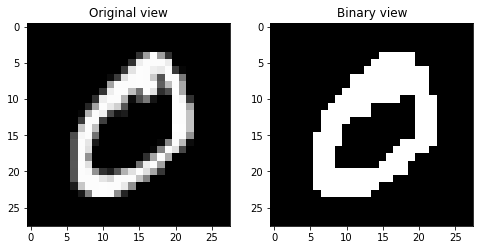

In [3]:
# Loading MNIST dataset
data = mnist.load_data()
shape_digit = (28, 28)
shape_message = (63, 28)
    
# Choosing the digit, let it be the zero
X_orig = data[0][0][1].flatten()

# Make it binary
threshold = 0
X = X_orig.copy()
X[X_orig <= threshold] = 0
X[X_orig > threshold] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_title("Original view")
ax1.imshow(X_orig.reshape(shape_digit), cmap='gray')
ax2.set_title("Binary view")
ax2.imshow(X.reshape(shape_digit), cmap='gray')
plt.show()

## Encoding and transmitting through noisy channel

In [4]:
def encode(X, G, noise_std):
    def generate_noise(noise_size, noise_std, noise_mean=0):
        return np.random.normal(loc=noise_mean, scale=noise_std, size=noise_size)

    # Encoding
    message_encoded = (X @ G) % 2
    message_encoded[message_encoded == 1] = -1
    message_encoded[message_encoded == 0] = 1
    noise_vector = generate_noise(message_encoded.shape, noise_std)
    message_received = message_encoded + noise_vector
    
    return message_received, message_encoded

def show_messages(message_received, message_encoded):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))
    ax1.set_title("Encoded message")
    ax1.imshow(message_encoded.reshape(shape_message), cmap='gray')
    ax2.set_title("Recieved message")
    ax2.imshow(message_received.reshape(shape_message), cmap='gray')
    plt.show()

def show_results(results_a):
    cols = 5 if len(results_a) > 5 else len(results_a)
    rows = int(np.ceil(len(results_a) / 5))
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols, 7*rows))
    axs = axs.flatten()
    for i, (res, ax) in enumerate(zip(results_a, axs)):
        ax.set_title(f"Step {i + 1}, Error bits: {res[1]}")
        ax.imshow(res[0].reshape(shape_message), cmap='gray')
    plt.show()

def decode(mes, H, noise_std, max_iterations=30):
    # Initialization
    eps = 1e-10  # just a small number
    results = []
    if noise_std == 0:
        L_channel = (2 * mes) / eps
    else:
        L_channel = (2 * mes) / noise_std
    
    Lv = np.zeros_like(mes)
    
    Lc_prod = np.ones_like(H, dtype=float)
    for i in range(len(L_channel)):
        Lc_prod.T[i][H.T[i] == 1] = np.tanh(L_channel[i] / 2)
    Lc = Lc_prod.copy()
    
    # Decoding
    for iteration in range(max_iterations):
        
        # Check node update
        for i in range(H.shape[0]): 
            for j in np.arange(H.shape[1]):
                if H[i, j] == 1:
                    Lc_prod[i, j] = np.tanh(Lv[j] / 2)
            for j in np.arange(H.shape[1]):
                if H[i, j] == 1:
                    p = np.prod(Lc_prod[i][:j]) * np.prod(Lc_prod[i][j + 1:])
                    
                    if p == 1:
                        p -= eps  # Safe arctanh
                    elif p == -1:
                        p += eps  # Safe arctanh
                    
                    Lc[i, j] = 2 * np.arctanh(p)

        # Variable node update
        for i in range(len(Lv)):
            Lv[i] = L_channel[i] + np.sum(Lc.T[i][H.T[i] == 1])
        
        # Result for the current iteration (translating to final "hard" decision)
        res = np.sign(Lv)
        res[res == 1] = 0
        res[res == -1] = 1
        error_bits = int(((H @ res) % 2).sum())
        results.append([res, error_bits])
        
        # Early stopping (if no errors)
        if error_bits == 0:
            break

    return results

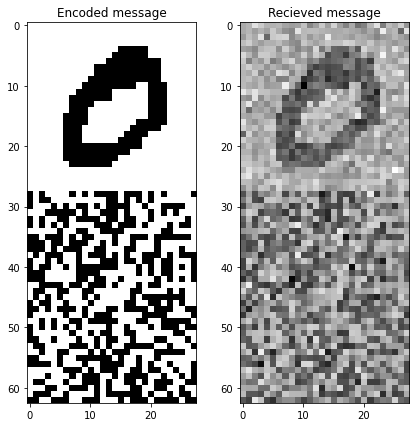

In [5]:
noise_std = 0.6
message_received, message_encoded = encode(X, G, noise_std)

show_messages(message_received, message_encoded)

## Decoding

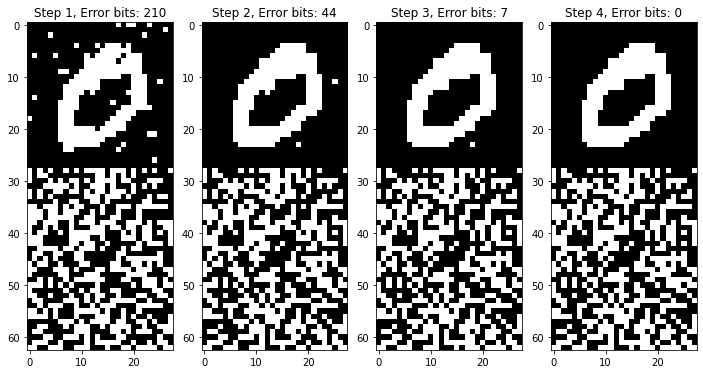

In [6]:
r = decode(message_received, H, noise_std, max_iterations=15)
show_results(r)

## Statistics

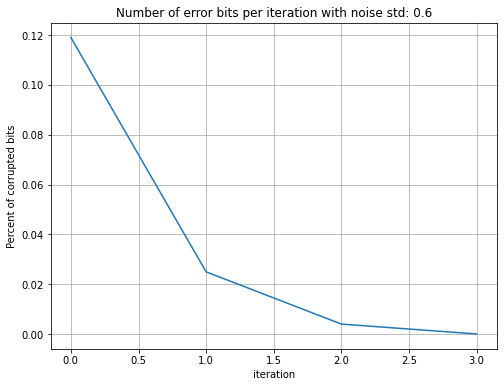

In [7]:
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.plot([i for i in range(len(r))], [res[1] / (shape_message[0] * shape_message[1]) for res in r])
plt.title(f"Number of error bits per iteration with noise std: {noise_std}")
plt.xlabel(f"iteration")
plt.ylabel(f"Percent of corrupted bits")
plt.grid()
plt.show()

In [8]:
noise_stds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

took_iters = []
for ns in tqdm(noise_stds):
    message_received, message_encoded = encode(X, G, ns)
    results = decode(message_received, H, ns, max_iterations=30)
    took_iters.append(len(results))

100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


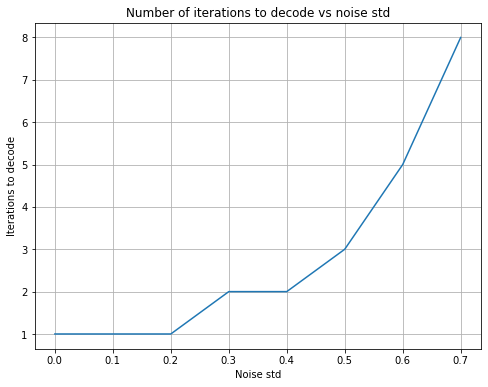

In [9]:
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.plot(noise_stds, took_iters)
plt.title(f"Number of iterations to decode vs noise std")
plt.xlabel(f"Noise std")
plt.ylabel(f"Iterations to decode")
plt.grid()
plt.show()